In [ ]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [ ]:
import zipfile

zip_path = "/content/Colorize.zip"

with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall("/content")

print("Extracted files:")
os.listdir("/content")

Extracted files:


['.config', 'Colorize.zip', 'landscape Images', 'sample_data']

In [ ]:
GRAY_DIR = "/content/landscape Images/gray"
COLOR_DIR = "/content/landscape Images/color"

print("Gray images:", len(os.listdir(GRAY_DIR)))
print("Color images:", len(os.listdir(COLOR_DIR)))

Gray images: 7129
Color images: 7129


In [ ]:
class LandscapeColorizationDataset(Dataset):
    def __init__(self, gray_dir, color_dir, img_size=224):
        self.gray_dir = gray_dir
        self.color_dir = color_dir
        self.gray_files = sorted(os.listdir(gray_dir))
        self.color_files = sorted(os.listdir(color_dir))
        self.img_size = img_size

        assert len(self.gray_files) == len(self.color_files), "Dataset mismatch!"

    def __len__(self):
        return len(self.gray_files)

    def __getitem__(self, idx):
        gray_path = os.path.join(self.gray_dir, self.gray_files[idx])
        color_path = os.path.join(self.color_dir, self.color_files[idx])

        # Load grayscale (H, W)
        gray = cv2.imread(gray_path, cv2.IMREAD_GRAYSCALE)

        # Load color (H, W, 3) in BGR
        color = cv2.imread(color_path)
        color = cv2.cvtColor(color, cv2.COLOR_BGR2RGB)

        # Resize both
        gray = cv2.resize(gray, (self.img_size, self.img_size))
        color = cv2.resize(color, (self.img_size, self.img_size))

        # Convert color to LAB
        lab = cv2.cvtColor(color, cv2.COLOR_RGB2LAB)
        L = lab[:, :, 0]
        AB = lab[:, :, 1:]

        # Normalize
        L = L / 255.0
        AB = (AB - 128) / 128.0

        # To tensors
        L = torch.tensor(L).unsqueeze(0).float()             # (1, H, W)
        AB = torch.tensor(AB).permute(2,0,1).float()         # (2, H, W)

        return L, AB

In [ ]:
dataset = LandscapeColorizationDataset(GRAY_DIR, COLOR_DIR, img_size=224)
loader = DataLoader(dataset, batch_size=8, shuffle=True)

print("Dataset size =", len(dataset))

Dataset size = 7129


In [ ]:
class ColorizationNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(128, 256, 3, stride=2, padding=1), nn.ReLU(),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(64, 2, 3, padding=1),
            nn.Tanh()   # AB in [-1,1]
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

model = ColorizationNet()
model

ColorizationNet(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): Tanh()
  )
)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 10

for epoch in range(epochs):
    running_loss = 0.0

    for L_batch, AB_batch in loader:
        L_batch = L_batch.to(device)
        AB_batch = AB_batch.to(device)

        optimizer.zero_grad()
        preds = model(L_batch)
        loss = criterion(preds, AB_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}] Loss: {running_loss/len(loader):.4f}")

Epoch [1/10] Loss: 0.8701
Epoch [2/10] Loss: 0.8671
Epoch [3/10] Loss: 0.8671
Epoch [4/10] Loss: 0.8671
Epoch [5/10] Loss: 0.8672
Epoch [6/10] Loss: 0.8669
Epoch [7/10] Loss: 0.8671
Epoch [8/10] Loss: 0.8670
Epoch [9/10] Loss: 0.8671
Epoch [10/10] Loss: 0.8671


In [ ]:
def lab_to_rgb(L, AB):
    L = (L * 255).astype("uint8")
    AB = (AB * 128 + 128).astype("uint8")

    lab = np.zeros((L.shape[0], L.shape[1], 3), dtype="uint8")
    lab[:,:,0] = L
    lab[:,:,1:] = AB

    rgb = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
    return rgb

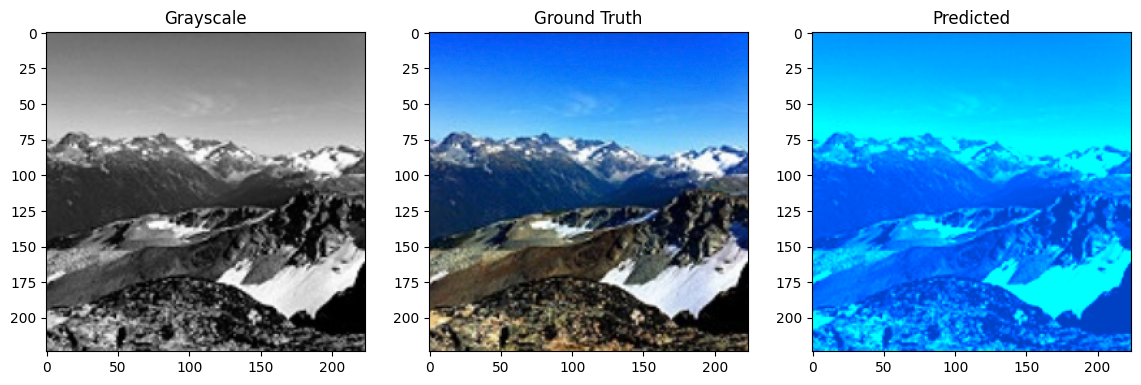

In [ ]:
idx = 10  # choose any index
L_img, AB_true = dataset[idx]

model.eval()
with torch.no_grad():
    AB_pred = model(L_img.unsqueeze(0).to(device)).cpu().squeeze(0).numpy()

# Convert all to numpy for RGB output
L_img_np = L_img.squeeze().numpy()
AB_pred_np = AB_pred.transpose(1,2,0)
AB_true_np = AB_true.numpy().transpose(1,2,0)

rgb_pred = lab_to_rgb(L_img_np, AB_pred_np)
rgb_true = lab_to_rgb(L_img_np, AB_true_np)

plt.figure(figsize=(14,5))

plt.subplot(1,3,1)
plt.title("Grayscale")
plt.imshow(L_img_np, cmap="gray")

plt.subplot(1,3,2)
plt.title("Ground Truth")
plt.imshow(rgb_true)

plt.subplot(1,3,3)
plt.title("Predicted")
plt.imshow(rgb_pred)

plt.show()